In [ ]:
#Importing neccessary libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf

In [ ]:
#Path to load the image dataset downloaded from Kaggle

In [25]:
train_dir = r'C:\Users\Moorthy\train'
val_dir = r'C:\Users\Moorthy\val'
test_dir = r'C:\Users\Moorthy\test'

In [ ]:
#Fitting the size of the image

In [26]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

In [ ]:
#Data augumentation improve model performance and rescaling the pixel size 

In [27]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
#Creating data flow of train, validate and test from directory 

In [28]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
#Pre trained Mobilnetv2 transformer for classifying presence of pnuemonia or not

In [29]:
 mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

9420800/9406464 [==============================] - 3s 0us/step


In [ ]:
#Training the pre trained transformer model with input and output layers 

In [30]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
#Setting the epoch, optimizer, and calculating loss

In [31]:
EPOCHS = 50

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
163/163 [==============================] - 157s 943ms/step - loss: 0.2022 - accuracy: 0.9229 - auc: 0.9667 - val_loss: 0.3174 - val_accuracy: 0.8750 - val_auc: 0.9531
Epoch 2/50
163/163 [==============================] - 144s 882ms/step - loss: 0.1163 - accuracy: 0.9525 - auc: 0.9891 - val_loss: 0.2918 - val_accuracy: 0.8750 - val_auc: 0.9688
Epoch 3/50
163/163 [==============================] - 149s 914ms/step - loss: 0.0953 - accuracy: 0.9601 - auc: 0.9925 - val_loss: 0.1680 - val_accuracy: 0.8750 - val_auc: 1.0000
Epoch 4/50
163/163 [==============================] - 142s 872ms/step - loss: 0.1180 - accuracy: 0.9523 - auc: 0.9878 - val_loss: 0.3889 - val_accuracy: 0.9375 - val_auc: 0.9531
Epoch 5/50
163/163 [==============================] - 143s 875ms/step - loss: 0.0818 - accuracy: 0.9670 - auc: 0.9943 - val_loss: 0.4338 - val_accuracy: 0.7500 - val_auc: 0.9688
Epoch 6/50
163/163 [==============================] - 143s 875ms/step - loss: 0.0815 - accuracy: 0.9686 - auc:

In [ ]:
#Plotting confusion matrix and setting threshold level for prediction

In [34]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))

cm = confusion_matrix(true_labels, pred_labels)

<ipython-input-34-edfc9550eec1>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))


In [ ]:
#Defining class for the variables

In [35]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
#Confusion matrix

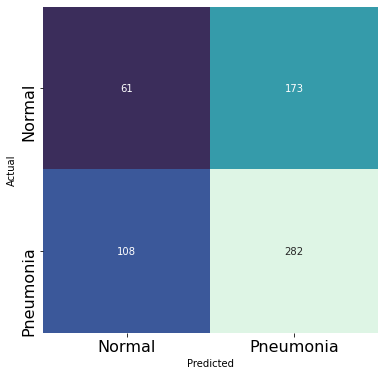

In [36]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [39]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [ ]:
#Accuracy and precision and recall

In [40]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [ ]:
#Evaluation metrics

In [41]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.85
AUC: 0.94
Precision: 0.62
Recall: 0.72
